 # Heston Option Pricing Model - Monte-Carlo Simulation


# Introduction

## The Heston Model (1993) is a useful model for simulating stochastic volatility and its effect on the potential paths an asset can take over the life of an option.

##While volatility is considered constant in BSM model, volatility in Heston model follows stochastic process.

##Heston model consists on 2 sets of Stichastic Differential Equations (SDE). The first one is to simulate stock price paths using Geometric Brownian Motion (GMB) and the second one is simulate stock volatility using a stochastic, mean-reverting process.

## $dS_t = \mu S_t dt + \sigma S_t dW_{t,S}$
## and
## $dV_t = \kappa(\theta - V_t)dt+\eta \sqrt{V_t}dW_{t,V}$

## such that $dW \sim N(0,dt)$.

## Given the correlation $\rho$ between the above 2 independen Brownian Motions, the covariance between $dW_{t,S}$ and $dW_{t,V}$ is
### $E[dW_{t,S}\cdot dW_{t,V}]=\rho \sqrt{dt}\sqrt{dt}=\rho dt$
##Variance $V = \sigma ^2$ and volatility $\sigma$.
##$dW_{t,S}$ Brownian motion of the asset price.
##$dW_{t,V}$ Brownian motion of the asset variance.

# Discretize Stock Price

## Under the real work measure, Geometric Brownian Motion SDE :
## $dS_t = \mu S_tdt + \sigma S_t dWt$,   
##drift = $\mu S_t$, and diffusion = $\sigma S_t$

##$\mu$ is the average growth rate of the asset and $\sigma$ is the associated volatility of the returns on the  asset. $dW$ is an increment of a BM, known as a Wiener process, such that $dW \sim N(0, dt)$.

##The value of $S$ is log-normally distributed and the returns $dS/S$ are normally distributed.

##Under the risk-neutral measure, it changes to :
### $dS_t = r S_tdt + \sigma S_t dWt$

##The good thing is that the closed form solution exists for this SDE. This is the solution of the Geometric Brownian Motion shown earlier.

### $S_{t+\delta t} = S_t \cdot exp[(\mu - 0.5\sigma^2) \delta t + \sigma W_{\delta t}]$


## Since $W_{\delta t} = Z\sqrt{\delta t}$, where $Z \sim N(0,1)$ :

### $S_{t+\delta t} = S_t \cdot exp[(\mu - 0.5\sigma ^2) \delta t + \sigma Z \sqrt{\delta t}]$ will give us the simulated asset prices.



# Discretize Variance

## $dV_t = \kappa(\theta - V_t)dt+\eta \sqrt{V_t}dW_{t}$

##Where :
##- $\kappa, \theta, \eta$ are all positive.
##- $\theta$ is the long run mean of the instantaneous variance.
##- $\kappa$ is the rate of mean-reversion. In other words, it is the rate at which $V_t$ reverts ti $\theta$.
##- $\eta$ is the volatility of volatility $(\sqrt{V_t})$.
##- These parameters should come from calibration. However, in this discussion, they are assumed for simplicity.

##Using Euler discretization :
### $V_{t+\delta t} = V_t + \kappa(\theta - V_t)\delta t + \eta \sqrt{V_t \delta t}Z$

# Simulation Steps

1. Start with the initial values $S_0$ for the stock price and $V_0$ for the variance.
2. Simulate variance (squared of volatility) : $V_{t+\delta t} = V_t + \kappa(\theta - V_t)\delta t + \eta \sqrt{V_t \delta t}Z$
3. Simulate Stock price : $S_{t+\delta t} = S_t \cdot exp[(\mu - 0.5\sigma ^2) \delta t + \sigma Z \sqrt{\delta t}]$
   Where $E[Z_S, Z_V]=\rho$

   The process for $V_T$ is guaranteed to remain positive as long as $\kappa \theta > 0.5 \eta^2$

   In equity markets, where we often witness increased  volatility associated with sharp negative returns, we would expect $\rho$ to be negative.

   In general, though, the model dos not require any particular sign of $\rho$.

5. Capture the terminal stock prices and compute option values
6. Compute present value of the mean of the computed option values.
   
   Remember this is nothing but a Monte-Carlo Simulation

# Simulations and Prices

 Let $Z_1$ and $Z_2$ be the 2 independent $N(0,1)$ random variables. We Now construct 2 correlated standard normal random variables as :

 $X = Z_1$

 $Y = \rho Z_1 + \sqrt{1-\rho^2}Z_2$



In [ ]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm, describe

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(4,2)

In [ ]:
#%%
def print_statistics(a1, a2) :
    """
    print selected statistics. Parameter : a1, a2 : ndarray objects generated from simulation
    """
    sta1 = describe(a1)
    sta2 = describe(a2)
    print('%14s %14s %14s' % ('Statistic', 'Data Set 1', 'Data Set 2'))
    print(45*'-')
    print('%14s %14.3f %14.3f' % ('size', sta1[0], sta2[0]))
    print('%14s %14.3f %14.3f' % ('min', sta1[1][0], sta2[1][0]))
    print('%14s %14.3f %14.3f' % ('max', sta1[1][1], sta2[1][1]))
    print('%14s %14.3f %14.3f' % ('mean', sta1[2], sta2[2]))
    print('%14s %14.3f %14.3f' % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print('%14s %14.3f %14.3f' % ('skew', sta1[4], sta2[4]))
    print('%14s %14.3f %14.3f' % ('kurtosis', sta1[5], sta2[5]))

In [ ]:
#%%
def simulate_stock_paths(S_0, V_0, T, r, kappa, theta, rho, eta, N, M):
    """
    parameters : S0 (initial stock price), T (time in years), r (risk-free rate), N (number of time steps), M (number of simulations)
    parameters from calibration :
        kappa (rate of mean reversion in variance process)
        rho (correlation between asset returns and variance)
        theta (long-term mean of variance process)
        eta (volatility of variance process)
    """
    dt = T/N # delta t, the length of time interval

    #Simulating M asset price paths witn N timesteps (N+1 array index). Rows = time steps, Columns = number of simulations
    V = np.zeros((N+1, M))
    V[0] = V0 #same as V[0][:], updates to 1st row and all columns
    S = np.zeros((N+1, M))
    S[0] = S0

    for i in range(1, N+1):
        #pseudo random numbers, returns an array of n random numbers.
        Z1 = np.random.standard_normal(M)
        Z2 = np.random.standard_normal(M)
        ZV = Z1
        ZS = rho*Z1 + math.sqrt(1 - rho**2)*Z2
        V[i] = V[i-1] + kappa*(theta - V[i-1])*dt + eta*np.sqrt(V[i-1]*dt)*ZV
        S[i] = S[i-1] * np.exp((r - 0.5 * V[i-1]) * dt + np.sqrt(V[i-1]*dt) * ZS)

    return S, V

In [ ]:
#%%
"""
Define parameters
Caution ! V is variance so squared volat !
"""
S0, V0, T, r = 100, 0.25**2, 10, 0.01

"""
These parameters should come from calibration !
"""
kappa, theta, eta, rho = 3, 0.3**2, 0.2, 0.5

N, M = 252, 1000

In [ ]:
#%%
S, V = simulate_stock_paths(S0, V0, T, r, kappa, theta, rho, eta, N, M)
S.shape, V.shape

((253, 1000), (253, 1000))

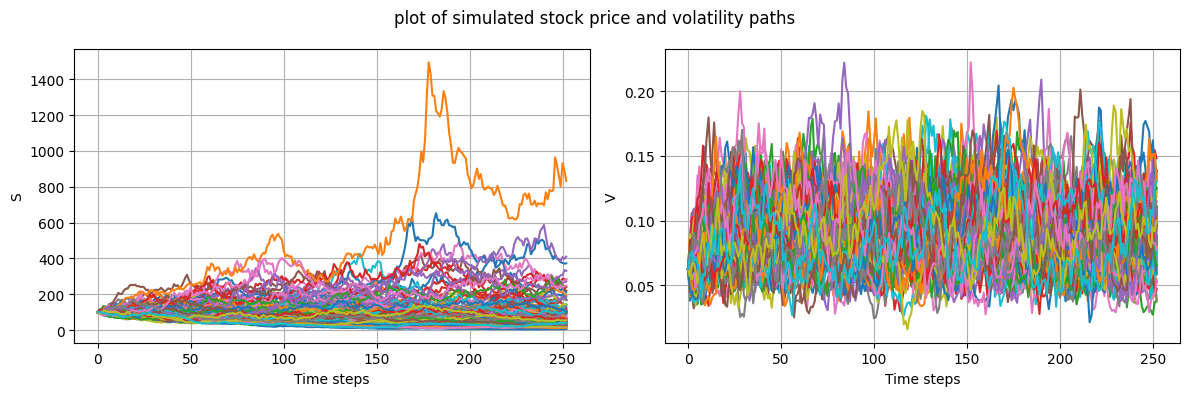

In [ ]:
#%%
"""
Plot initial 100 simulated stock price and volatility path using matplotlib
"""
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(S[:,:100])
plt.grid(True)
plt.xlabel('Time steps')
plt.ylabel('S')

plt.subplot(1, 2, 2)
plt.plot(V[:,:100])
plt.grid(True)
plt.xlabel('Time steps')
plt.ylabel('V')

plt.suptitle('plot of simulated stock price and volatility paths')
plt.tight_layout()
plt.show()

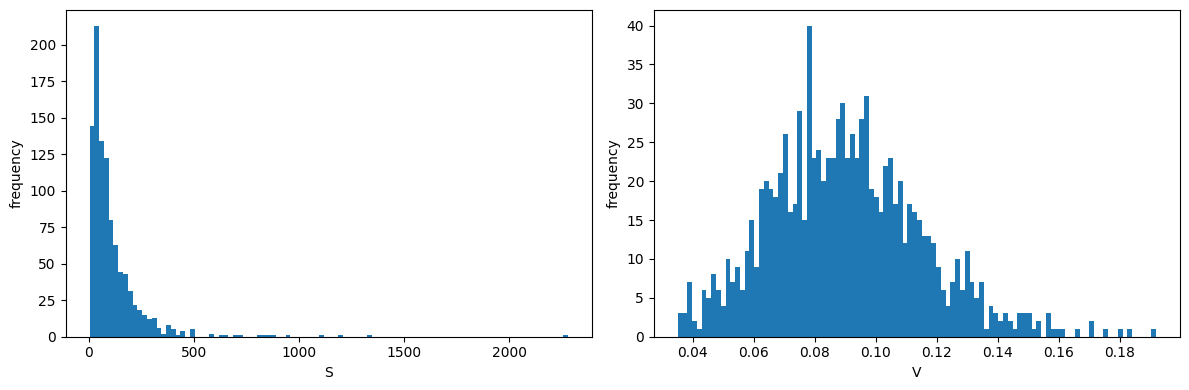

In [ ]:
#%%
"""
Plot the histogram of the simulated price paths at maturity
"""
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(S[-1], bins=100)
plt.xlabel('S')
plt.ylabel('frequency')

plt.subplot(1, 2, 2)
plt.hist(V[-1], bins=100)
plt.xlabel('V')
plt.ylabel('frequency')

plt.tight_layout()
plt.show()

In [ ]:
#%%
"""
Print the statistics of simulated data at maturity
"""
print_statistics(S[-1], V[-1])

     Statistic     Data Set 1     Data Set 2
---------------------------------------------
          size       1000.000       1000.000
           min          3.508          0.035
           max       2278.616          0.192
          mean        112.582          0.090
           std        144.755          0.025
          skew          6.036          0.484
      kurtosis         63.436          0.461


In [ ]:
#%%
"""
Assign simulated price paths to dataframe for analysis.
Verify the generated price paths.
Number of columns = number of simulations.
"""
df = pd.DataFrame(S)
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
248,795.785672,76.225944,43.954377,116.397741,127.348626,28.451372,172.202683,91.171002,78.163597,255.890332,...,66.496580,27.140613,121.219867,258.714738,409.167290,88.356118,21.325953,24.437160,68.467468,48.172526
249,687.717334,73.862651,40.810271,122.187768,121.372867,30.001925,185.748544,87.189323,86.718982,259.926357,...,65.351796,24.684224,122.064131,248.993052,398.871473,98.517282,21.497588,28.451066,66.821266,46.159325
250,697.347403,69.575616,41.671546,124.379526,120.042113,28.104544,199.968194,82.456922,83.106818,234.629350,...,62.361654,25.319208,113.586909,252.327700,379.257905,109.157928,21.315596,27.180361,62.763990,44.923268
251,672.279810,62.945372,43.102937,123.990920,121.125647,27.790121,201.245801,78.585934,91.446759,252.426141,...,59.873805,27.258752,115.110279,226.946925,360.069506,114.449764,21.915960,25.995515,65.069943,45.269031
252,616.309275,61.101754,44.588150,134.967380,123.530863,26.023660,188.114636,77.357357,88.491783,211.365579,...,63.385231,26.966168,111.964069,203.551583,353.863164,113.411588,22.414660,26.742106,62.727191,41.583817


## European Option

In [ ]:
K = 100

C0 = np.exp(-r*T)*np.mean(np.maximum(S[-1] - K, 0))
P0 = np.exp(-r*T)*np.mean(np.maximum(K - S[-1], 0))

print(f'European Call Option Value at t=0 :    {C0:0.4f}')
print(f'European Put Option Value at t=0 :     {P0:0.4f}')

European Call Option Value at t=0 :    41.0760
European Put Option Value at t=0 :     29.6910


Heston model can give more accurate results when we calibrate Heston model with accurate data.

## Comparison with BSM

In [ ]:
def BSM(S0=100, K=100, T=1, r=0.05, sigma=0.02, option_type='call'):
    d1 = (math.log(S0/K) + (r+sigma**2/2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    N = norm.cdf
    V = 0
    if (option_type=='call'):
        V = S0*N(d1)-K*math.exp(-r*T)*N(d2)
    elif (option_type=='put'):
        V = K*math.exp(-r*T)*N(-d2) - S0*N(-d1)
    del N
    return V

C = BSM(sigma=0.25)
P = BSM(sigma=0.25,option_type='put')

print('ATM CALL %.2f; ATM Put %.2f' % (C,P))

ATM CALL 12.34; ATM Put 7.46


# Calibration




###The calibration of the Heston model entails fine-tuning its five intrinsic parameters (long-term variance $\theta$, mean reversion rate $\kappa$, volatility of volatility $\sigma$, correlation between asset returns and volatility $\rho$, and initial variance $V_0$) to align the model's theoretical option prices closely with those observed in the market. This process leverages numerical optimization techniques to minimize the discrepancy between market and model-generated prices across a range of strikes and maturities.

### Effective calibration not only enhances the model's pricing accuracy but also improves its utility in risk management and hedging strategies.

###Also, this task is computationally demanding, sensitive to market data quality, and requires ongoing recalibration to adapt to evolving market dynamics, thereby ensuring the model's parameters remain reflective of the underlying asset's stochastic volatility behavior.

## Get Option Data

In [ ]:
!pip install yahoo_fin

In [ ]:
from yahoo_fin import options as op
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, bisect, newton, fmin

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
ticker = 'PLTR'

expirationDates = op.get_expiration_dates(ticker)

WholeCallData = pd.DataFrame()
for _ in range(len(expirationDates)):
    WholeCallData = pd.concat([WholeCallData, op.get_calls(ticker, date = expirationDates[_])])

def extract_maturity(option_code):
    year = option_code[4:6]
    month = option_code[6:8]
    day = option_code[8:10]
    return f"20{year}-{month}-{day}"

WholeCallData['maturity_date'] = WholeCallData['Contract Name'].apply(extract_maturity)
WholeCallData['maturity_date'] = pd.to_datetime(WholeCallData['maturity_date'])

WholeCallData["Last Trade Date"] = pd.to_datetime(WholeCallData["Last Trade Date"]).dt.tz_localize(None)
WholeCallData["Last Trade Date"] = WholeCallData["Last Trade Date"].dt.strftime('%Y-%m-%d')

WholeCallData['tau_to_matu_days'] = (WholeCallData['maturity_date'] - pd.Timestamp(datetime.now())).dt.days
WholeCallData['tau_to_matu_years'] = WholeCallData['tau_to_matu_days'] / 365.25

WholeCallData['Mid'] = (WholeCallData['Bid'] + WholeCallData['Ask'])/2

WholeCallData = WholeCallData[['Contract Name','tau_to_matu_days',
       'tau_to_matu_years',  'Strike', 'Bid',
       'Ask', 'Mid', 'Volume', 'Implied Volatility', 'Last Trade Date', 'maturity_date', ]]

WholeCallData.columns = ['Ticker','Maturity_days',
       'Maturity_years',  'Strike', 'Bid',
       'Ask', 'Mid', 'Volm','Implied Volatility Yahoo', 'Last Trade Date', 'maturity_date']

WholeCallData.head()


/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,Ticker,Maturity_days,Maturity_years,Strike,Bid,Ask,Mid,Volm,Implied Volatility Yahoo,Last Trade Date,maturity_date
0,PLTR240216C00001000,3,0.008214,1.0,23.70,25.75,24.725,15,"2,768.75%",2024-02-12,2024-02-16
1,PLTR240216C00002000,3,0.008214,2.0,23.00,23.15,23.075,2,"1,025.00%",2024-02-08,2024-02-16
2,PLTR240216C00003000,3,0.008214,3.0,21.95,22.40,22.175,1,912.50%,2024-02-08,2024-02-16
3,PLTR240216C00004000,3,0.008214,4.0,20.15,21.05,20.600,1,0.00%,2024-02-06,2024-02-16
4,PLTR240216C00005000,3,0.008214,5.0,19.90,20.15,20.025,4,643.75%,2024-02-09,2024-02-16


In [ ]:
dff = WholeCallData.copy()

dff["Last Trade Date"].value_counts()

2024-02-12    454
2024-02-09     68
2024-02-08     20
2024-02-06     18
2024-02-07     11
2024-01-24      2
2024-01-16      1
2024-01-31      1
2023-12-14      1
2023-12-12      1
2024-01-18      1
2024-01-02      1
2024-01-19      1
2024-01-17      1
Name: Last Trade Date, dtype: int64

### Keeping only options that were last traded today, so we have same underlying price and a more precise calibration.

In [ ]:
dff = dff[dff["Last Trade Date"]=="2024-02-12"]

dff["Last Trade Date"].value_counts()

2024-02-12    454
Name: Last Trade Date, dtype: int64

### Same process, removing those that have a maturity date today.

In [ ]:
dff["maturity_date"].value_counts()

2024-02-16    46
2024-02-23    37
2024-03-01    35
2024-05-17    32
2024-03-15    31
2024-03-08    31
2024-03-22    30
2024-04-19    30
2024-06-21    29
2024-07-19    28
2024-08-16    26
2024-09-20    23
2024-03-28    22
2025-01-17    15
2026-01-16    14
2025-06-20    13
2024-12-20    12
Name: maturity_date, dtype: int64

In [ ]:
dff = dff[dff["maturity_date"]!="2024-02-12"]
dff["maturity_date"].value_counts()

2024-02-16    46
2024-02-23    37
2024-03-01    35
2024-05-17    32
2024-03-15    31
2024-03-08    31
2024-03-22    30
2024-04-19    30
2024-06-21    29
2024-07-19    28
2024-08-16    26
2024-09-20    23
2024-03-28    22
2025-01-17    15
2026-01-16    14
2025-06-20    13
2024-12-20    12
Name: maturity_date, dtype: int64

In [ ]:
dff

,Ticker,Maturity_days,Maturity_years,Strike,Bid,Ask,Mid,Volm,Implied Volatility Yahoo,Last Trade Date,maturity_date
0,PLTR240216C00001000,3,0.008214,1.0,23.70,25.75,24.725,15,"2,768.75%",2024-02-12,2024-02-16
5,PLTR240216C00006000,3,0.008214,6.0,18.95,19.05,19.000,2,0.00%,2024-02-12,2024-02-16
7,PLTR240216C00008000,3,0.008214,8.0,17.05,17.75,17.400,2,649.22%,2024-02-12,2024-02-16
8,PLTR240216C00009000,3,0.008214,9.0,14.40,16.10,15.250,25,0.00%,2024-02-12,2024-02-16
11,PLTR240216C00011500,3,0.008214,11.5,13.45,13.60,13.525,2,0.00%,2024-02-12,2024-02-16
...,...,...,...,...,...,...,...,...,...,...,...
10,PLTR260116C00027000,703,1.924709,27.0,8.25,8.40,8.325,1845,66.24%,2024-02-12,2026-01-16
11,PLTR260116C00030000,703,1.924709,30.0,7.35,7.45,7.400,1354,65.50%,2024-02-12,2026-01-16
12,PLTR260116C00035000,703,1.924709,35.0,6.05,6.15,6.100,109,64.45%,2024-02-12,2026-01-16
13,PLTR260116C00037000,703,1.924709,37.0,5.65,5.75,5.700,39,64.42%,2024-02-12,2026-01-16


## Before delving into the calibration, The dataframe should have this form for the algorithm :



[Ticker,	Maturity_days,	Strike,	Bid,	Ask,	Mid,	Volm]


- **Ticker** : This column is initially the column 'Contract Name' and provides informations about each option : the underlying, the maturity date and the strike.

- **Maturity_days** : This column indicates the number of days until the option's expiration.

- **Strike** : The predetermined price at which the underlying asset can be bought (for call options) or sold (for put options) when the option is exercised.

- **Mid** : The mid-price of the option. Calculated as the average of the bid and ask prices.

- **Bid** : The highest price a buyer is willing to pay for the option.

- **Ask** : The lowest price a seller is willing to sell the option for.

- **Volm** : Volume of the option trades for the given period. Represents the number of contracts traded.


In [ ]:
df = dff[['Ticker', 'Maturity_days', 'Strike', 'Bid', 'Ask', 'Mid', 'Volm']]
df

,Ticker,Maturity_days,Strike,Bid,Ask,Mid,Volm
0,PLTR240216C00001000,3,1.0,23.70,25.75,24.725,15
5,PLTR240216C00006000,3,6.0,18.95,19.05,19.000,2
7,PLTR240216C00008000,3,8.0,17.05,17.75,17.400,2
8,PLTR240216C00009000,3,9.0,14.40,16.10,15.250,25
11,PLTR240216C00011500,3,11.5,13.45,13.60,13.525,2
...,...,...,...,...,...,...,...
10,PLTR260116C00027000,703,27.0,8.25,8.40,8.325,1845
11,PLTR260116C00030000,703,30.0,7.35,7.45,7.400,1354
12,PLTR260116C00035000,703,35.0,6.05,6.15,6.100,109
13,PLTR260116C00037000,703,37.0,5.65,5.75,5.700,39


## Getting the Spot price (price of the underlying at the time of pricing)

In [ ]:
tickerData = yf.Ticker(ticker)
tickerDf = tickerData.history(period='1d')

current_stock_price = tickerDf['Close'][-1]

print("S_t =", current_stock_price)

S_t = 25.059999465942383


## With this kind of dataset in hand, we aim to calibrate our models to best represent the observed Call Prices

### 1. **Geometric Brownian Motion (GBM)**

#### The GBM model is one of the foundational models for option pricing, especially known for its use in the Black-Scholes formula. Under this framework, the stock price is assumed to follow a geometric Brownian motion with constant volatility, also termed as 'implied volatility'.

#### Equation
$ dS(t) = \mu S(t) dt + \sigma S(t) dW(t) $

### Calibration Goal:

- **Implied Volatility:** We aim to calibrate the constant volatility parameter **$\sigma$** such that the model prices are as close as possible to the observed market prices.
___
### 2. **Heston Model**

#### The Heston model, on the other hand, is a more advanced stochastic volatility model. It assumes that the volatility of the asset is not constant, nor even deterministic, but follows a random process.

##### Equation
$$ dS(t) = (r-q) S(t) dt + \sqrt{v(t)} S(t) dW_1(t) $$
$$ dv(t) = \kappa (\theta - v(t)) dt + \lambda \sqrt{v(t)} dW_2(t) $$

### Calibration Goal:

#### Our aim is to calibrate the model parameters, including the long-term mean volatility **$\theta$**, the mean-reversion rate **$\kappa$**, the correlation **$\rho$** between the two  Wiener processes, the initial variance **$\nu_0$**, and the volatility of the volatility parameter **$\lambda$**.
We will leverage two different calibration methods:

- **Nelson's Gradient-Free Approach:** A sophisticated optimization technique that attempts to locate the best parameter values without the explicit need for gradient information.

- **BLSF Algorithm:** An advanced method known for its robustness in finding optimal solutions.


## Import packages

In [ ]:
import warnings  # importing the warnings library for controlling warning messages
warnings.filterwarnings("ignore")  # configuring the warnings to be ignored, effectively suppressing them

import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
from scipy.optimize import fmin, fmin_bfgs

import cmath  # importing the complex math library for operations on complex numbers
import math  # importing the math library for mathematical operations


## Plotting Option Surfaces

### Overview

When visualizing financial instruments like options, plotting option surfaces provides a comprehensive representation of the option prices in relation to the strike prices and the maturity dates. In this document, we specifically focus on creating visual representations for the company call and put options, utilizing linear interpolation to account for missing strikes, ensuring a smoother and more accurate surface.

### Objective

The main objective is to illustrate the intricacies of the company options with varying strike prices and maturity dates, enabling easier analysis of option dynamics for traders and analysts. These surface plots can give a quick visual intuition about the premium one has to pay for a given strike and maturity.

### Methodology

Linear Interpolation

- Given the likely scenario where not all combinations of strike price and maturity have corresponding option prices, we utilize linear interpolation for generating approximations for the missing data points.
- The `scipy.interpolate.interp1d` function is used, which computes linear interpolations of the option price, ensuring the surface plot is coherent and uninterrupted. If the data point is outside the available range, it extrapolates the values.






In [ ]:
from matplotlib import cm  # importing color maps from matplotlib for visual enhancement
from scipy import interpolate  # importing interpolation functions from scipy to fit data points



def readNPlot(df, ticker, figsize=(8,6)):
    strikes = np.sort(df["Strike"].unique())
    maturities = np.sort(df["Maturity_days"].unique())
    # creating a meshgrid for strikes and maturities, essential for 3D plotting
    X, Y = np.meshgrid(strikes, maturities)
    # initializing an empty array to store option prices
    callPrices = np.empty([len(maturities), len(strikes)])

    # looping through each maturity to interpolate option prices
    for i in range(len(maturities)):
        # selecting strike prices for the given maturity
        s = df[df.Maturity_days == maturities[i]]['Strike']
        # selecting corresponding option prices for the given maturity
        price = df[df.Maturity_days == maturities[i]]['Mid']
        # using linear interpolation to estimate option prices for all strikes
        f = interpolate.interp1d(s, price, kind='linear', bounds_error=False, fill_value="extrapolate")
        # storing interpolated prices into the callPrices array
        callPrices[i, :] = f(strikes)

    fig = plt.figure(figsize = figsize)
    # adding a 3D subplot to the figure
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, callPrices, cmap=cm.coolwarm)
    ax.set_ylabel('Maturity (days)')
    ax.set_xlabel('Strike')
    ax.set_zlabel('C(K, T)')
    ax.set_title(ticker + ' Calls - Option Surface')

    return maturities, strikes, callPrices, fig



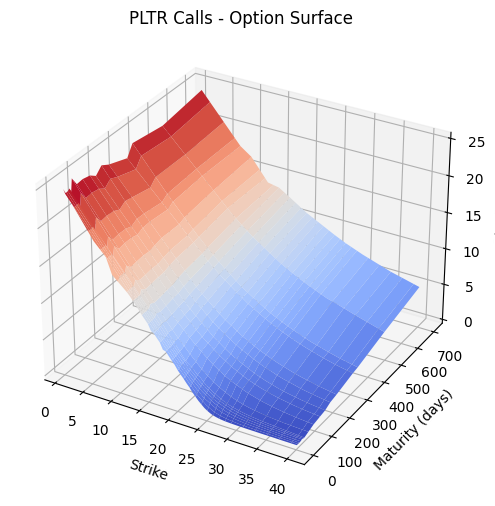

In [ ]:
# passing in the DataFrame, the ticker, and the figure size, then unpacking the returned values into maturities, strikes, Prices, and fig
maturities, strikes, Prices, fig = readNPlot(df, ticker, figsize=(8,6))

In [ ]:

def myRange(start, finish, increment):
  """
  defining a custom range function with start, finish, and increment as arguments
  """
  myZero = 1e-17  # defining a very small number close to zero
  while (start <= finish+myZero):  # looping until start is less than or equal to finish plus the small number
    yield start  # yielding the current start value
    start += increment  # incrementing the start value


def paramMapping(x, c, d):
  """
  defining a function to perform periodic linear extension mapping
  """
  if ((x>=c) & (x<=d)): y = x  # assigning x to y
  else:
    range = d-c  # calculating the difference between d and c
    n = math.floor((x-c)/range)  # calculating the floor value of the division
    if (n%2 == 0):  y = x - n*range  # calculating y based on n and range
    else: y = d + n*range - (x-c)  # calculating y based on d, n, range and x
  return y  # returning the calculated y value



def eValue(params, *args):
    """
    Calculates RMSE : Error Value -> eValue
    """
    marketPrices = args[0]  # extracting market prices from args
    maturities = args[1]  # extracting maturities from args
    strikes = args[2]  # extracting strikes from args
    r = args[3]  # extracting r value from args
    q = args[4]  # extracting q value from args
    S0 = args[5]  # extracting initial stock price from args
    alpha = args[6]  # extracting alpha value from args
    eta = args[7]  # extracting eta value from args
    n = args[8]  # extracting n value from args
    model = args[9]  # extracting model type from args

    lenT = len(maturities)  # getting the length of maturities
    lenK = len(strikes)  # getting the length of strikes

    modelPrices = np.zeros((lenT, lenK))  # initializing an array of zeros for model prices

    count = 0  # initializing a counter
    mae = 0  # initializing the mean absolute error
    for i in range(lenT):  # looping through each maturity
        for j in range(lenK):  # looping through each strike
            count  = count+1  # incrementing the counter
            T = maturities[i]  # getting the current maturity
            K = strikes[j]  # getting the current strike
            [km, cT_km] = genericFFT(params, S0, K, r, q, T, alpha, eta, n, model)  # computing km and cT_km using the genericFFT function
            modelPrices[i,j] = cT_km[0]  # assigning the calculated model price to the matrix
            tmp = marketPrices[i,j]-modelPrices[i,j]  # computing the difference between market and model prices
            mae += tmp**2  # accumulating the square of differences

    rmse = math.sqrt(mae/count)  # calculating the root mean square error
    return rmse  # returning the calculated error



def generic_CF(u, params, S0, r, q, T, model):
    """
    defining a function to compute the characteristic function of a given model
    """
    # logic for Geometric Brownian Motion (GBM) model
    if (model == 'GBM'):
        sig = params[0]  # extracting sigma from parameters
        mu = np.log(S0) + (r-q-sig**2/2)*T  # calculating mu value
        a = sig*np.sqrt(T)  # calculating a value
        phi = np.exp(1j*mu*u-(a*u)**2/2)  # calculating the characteristic function for GBM

    # logic for Heston model
    elif(model == 'Heston'):
        # extracting parameters for the Heston model
        kappa  = params[0]
        theta  = params[1]
        sigma  = params[2]
        rho    = params[3]
        v0     = params[4]

        # mapping parameters to specific ranges
        kappa = paramMapping(kappa,0.1, 20)
        theta = paramMapping(theta,0.001, 0.4)
        sigma = paramMapping(sigma,0.01, 0.6)
        rho   = paramMapping(rho  ,-1.0, 1.0)
        v0    = paramMapping(v0   ,0.005, 0.25)

        # calculations for Heston model characteristic function
        tmp = (kappa-1j*rho*sigma*u)
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2)
        pow1 = 2*kappa*theta/(sigma**2)
        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2))
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp)
        log_phi = numer1 - log_denum1 - tmp2
        phi = np.exp(log_phi)

    return phi  # returning the calculated characteristic function



def genericFFT(params, S0, K, r, q, T, alpha, eta, n, model):
    """
    defining a function to compute option prices using the Fast Fourier Transform (FFT) method
    """

    N = 2**n  # calculating the size of the FFT

    lda = (2*np.pi/N)/eta  # calculating the step-size in log strike space

    beta = np.log(K)  # choosing beta as the logarithm of strike price

    km = np.zeros((N))  # initializing an array of zeros for km values
    xX = np.zeros((N))  # initializing an array of zeros for x values

    df = math.exp(-r*T)  # calculating the discount factor

    nuJ = np.arange(N)*eta  # creating an array of nu values multiplied by eta

    psi_nuJ = generic_CF(nuJ-(alpha+1)*1j, params, S0, r, q, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))  # calculating psi_nu values using the characteristic function

    # loop to calculate x values for FFT
    for j in range(N):
        km[j] = beta+j*lda  # calculating km values
        if j == 0:
            wJ = (eta/2)  # adjusting the weight for the first iteration
        else:
            wJ = eta  # using eta as the weight for subsequent iterations
        xX[j] = cmath.exp(-1j*beta*nuJ[j])*df*psi_nuJ[j]*wJ  # calculating x values for FFT

    yY = np.fft.fft(xX)  # performing the FFT on x values
    cT_km = np.zeros((N))  # initializing an array of zeros for cT_km values

    # loop to calculate option prices using the FFT results
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi  # calculating the multiplier for option prices
        cT_km[i] = multiplier*np.real(yY[i])  # calculating option prices

    return km, cT_km  # returning km values and option prices


## 1. **Geometric Brownian Motion (GBM) - Model Calibration: Calculating implied volatility -> Done by Hugo**

In [ ]:
# defining function to compute d1 for the Black-Scholes formula
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1  # returning the computed value of d1

# defining function to compute d2 for the Black-Scholes formula
def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2  # returning the computed value of d2

# defining function to compute Black-Scholes price for 'call' or 'put' options
def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t  # calculating time to expiration (tau)
    d1 = BS_d1(S, K, r, q, sigma, tau)  # calculating d1
    d2 = BS_d2(S, K, r, q, sigma, tau)  # calculating d2

    # calculating price for call options
    if type_option == 'Call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    # calculating price for put options
    elif type_option == 'Put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1)
    return price  # returning the calculated option price

# defining auxiliary function for computing implied volatility
def aux_imp_vol(sigma, P, type_option, S, K, r, q, T, t=0):
    ''' Auxiliary function for computing implied volatility '''
    # computing Black-Scholes price for given sigma and other parameters
    BS_P = BS_price(type_option, S, K, r, q, sigma, T, t)
    # returning the difference between the actual price and Black-Scholes price
    return P - BS_P

## 2. **Heston Model - Model Calibration: Finding the best parameters**

### *Starting from an initial set of parameters*

In [ ]:
# specifying the model to be used as 'Heston'
model = 'Heston'

# setting the alpha parameter to 1.5
alpha = 1.5

# setting the eta parameter to 0.2
eta = 0.2

# setting the n parameter to 12
n = 12

# defining a tuple of parameters for the first set of model parameters
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)

# defining a tuple of parameters for the second set of model parameters
#params2 = (3.0, 0.06, 0.10, -0.6, 0.04)

# alternative sets of parameters for more aggressive or more conservative scenarios are commented out for future reference or use
# more aggressive mean reversion, higher long-term mean, higher volatility of volatility, positive correlation, higher initial volatility
#params2 = (2.5, 0.07, 0.12, 0.3, 0.1)
# lower mean reversion, lower long-term mean, lower volatility of volatility, near-zero correlation, lower initial volatility
params2 = (0.8, 0.01, 0.03, 0.1, 0.02)

- mean-reversion rate **$\kappa$**,
- long-term mean volatility **$\theta$**,
- the volatility of the volatility parameter **$\lambda$**,
- correlation **$\rho$** between the two  Wiener processes,
- the initial variance **$\nu_0$**.

### CALL Options - Initial Parameters Scanner using the RMSE Function

To evaluate the quality of the model in fitting call option prices, we can use the Root Mean Square Error (RMSE) function.
-  The RMSE is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (P_{\text{obs},i} - P_{\text{model},i})^2}
$$

- **$P_{\text{obs},i}$**: The observed (market) price of the ith call option.
- **$P_{\text{model},i}$**: The model-predicted price of the ith call option.
- **$N$**: The total number of observations.

### The RMSE function provides a measure of the average deviation of the model-predicted prices from the observed prices.
### A lower RMSE value indicates a better fit.


In [ ]:
df.head(60)

In [ ]:
K = 20  # setting the strike price of the option to 190
T_days = 10  # setting the time to expiration in days to 151
T_years = T_days / 365  # converting the time to expiration to years

# dividend rate
q = 0.00  # setting the dividend rate to 0.005

# risk free rate
r = 0.03905  # setting the risk-free interest rate to 0.0245

# spot price
S0 = current_stock_price  # setting the spot price of the stock to the variable current_stock_price

# price
P_call = 5.1  # setting the price of the call option

### initial guess : we will try combinations of params 1 and 2 and select the best RMSE.

In [ ]:
%%time
# *** THIS TAKES TIME TO RUN ***

# Initialize optimParams with a default value (e.g., params1 or a zero array of the same size)
#optimParams = np.array(params1)  # Adjust as needed based on your context

# initializing an empty list to store the 'i' values
iArray = []

# initializing an empty list to store the RMSE values
rmseArray = []

# setting an initial high value for minimum RMSE for comparison
rmseMin = 1e10

# specifying the type of option as "Call"
option_type = "Call"

# setting the market prices based on the read Prices
marketPrices = Prices

# converting maturities to years from days
maturities_years = maturities / 365.0


# looping through a range of 'i' values from 0 to 1 with a step of 0.05
for i in myRange(0, 1, 0.05):
    # calculating a weighted average of params1 and params2 based on 'i'
    params = i * np.array(params1) + (1.0 - i) * np.array(params2)

    # appending the current value of 'i' to the iArray list
    iArray.append(i)

    # calculating the RMSE using the eValue function from the mfc module
    rmse = eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

    # appending the calculated RMSE to the rmseArray list
    rmseArray.append(rmse)

    # checking if the calculated RMSE is less than the current minimum RMSE
    if rmse < rmseMin:
        rmseMin = rmse  # updating the minimum RMSE
        optimParams = params  # storing the parameters that resulted in the minimum RMSE

print("")

# printing the minimum RMSE and the optimal parameters on the same line
print("Minimum RMSE: {} - Optimal Initial Parameters: {}".format(rmseMin, optimParams))


Minimum RMSE: 1.720447540833881 - Optimal Initial Parameters: [ 0.99    0.0195  0.049  -0.375   0.077 ]
CPU times: user 6min 18s, sys: 431 ms, total: 6min 18s
Wall time: 6min 22s


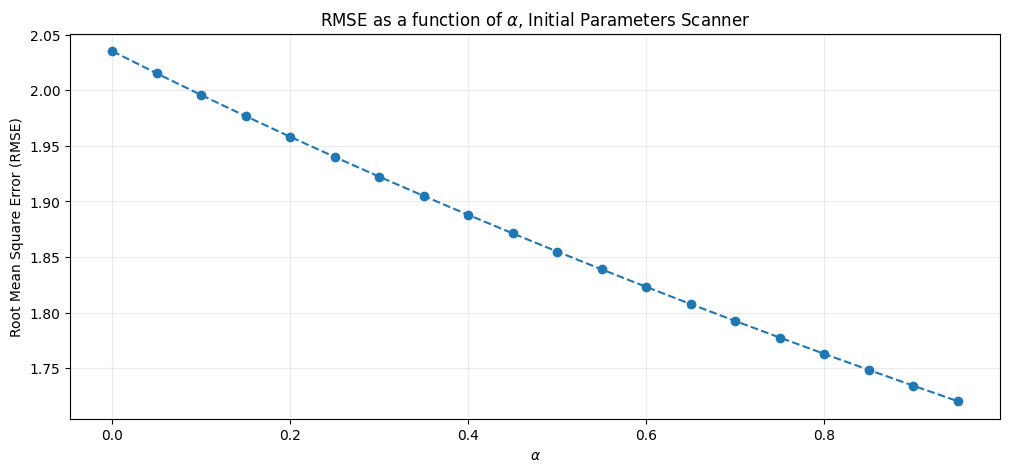

In [ ]:
# creating a new figure with dimensions 15x5 for plotting
fig = plt.figure(figsize=(12,5))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha = 0.25)
plt.xlabel(r'$\alpha$')
plt.ylabel('Root Mean Square Error (RMSE)')
plt.title(r'RMSE as a function of $\alpha$, Initial Parameters Scanner')
plt.show()

## **Nelson's Gradient-Free Approach**

- mean-reversion rate **$\kappa$**,
- long-term mean volatility **$\theta$**,
- the volatility of the volatility parameter **$\lambda$**,
- correlation **$\rho$** between the two  Wiener processes,
- the initial variance **$\nu_0$**.

In [ ]:
initial_guess = optimParams
initial_guess

array([ 0.99  ,  0.0195,  0.049 , -0.375 ,  0.077 ])

In [ ]:
rmseMin

1.720447540833881

### The goal now is to further reduce the root mean square error (RMSE) of the initial guess using Nelson's Gradient-Free Optimization Method.

In [ ]:
#%%time

# ******************************
# *** THIS TAKES TIME TO RUN ***
# ******************************

# initializing the arguments for the optimization function
arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

# performing the optimization using the fmin function from scipy.optimize
# t contains the output including optimal parameters and function value
t = fmin(
    eValue,           # function to be minimized
    initial_guess,        # initial parameter guess, from the above cells
    args = arg,           # extra arguments passed to mfc.eValue
    maxiter = 20,         # maximum number of iterations - 20
    maxfun = 100,         # maximum number of function evaluations
    disp = True,          # flag to display convergence messages
    retall = False,       # flag to return all parameter vectors
    full_output = True    # flag to return fopt, iterations, etc. in addition to xopt
)


# assigning the minimum RMSE and the optimal parameters
rmseMinNelson = t[1]
optimParamsNelson = t[0]

# printing the minimum RMSE and the optimal parameters on the same line
print("Minimum RMSE: {} - Optimal Nelson's Parameters: {}".format(rmseMinNelson, optimParamsNelson))

Minimum RMSE: 0.7800505924324227 - Optimal Nelson's Parameters: [ 0.12403158  0.05858482 -0.00512409  0.42595234  0.2733588 ]


### *Sanity Check - Using the `eValue` Function with the `optimParamsNelson` parameters*

- mean-reversion rate **$\kappa$**,
- long-term mean volatility **$\theta$**,
- the volatility of the volatility parameter **$\lambda$**,
- correlation **$\rho$** between the two  Wiener processes,
- the initial variance **$\nu_0$**.

In [ ]:
params = optimParamsNelson
rmse = eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
round(rmse,5)

0.78005

In [ ]:
print(f"Improvement of {rmseMin - rmseMinNelson}, from the Initial Guess to the Nelson's Gradient-Free Method")

Improvement of 0.9403969484014584, from the Initial Guess to the Nelson's Gradient-Free Method


## **BLSF Algorithm Approach**

In [ ]:
optimParamsNelson

array([ 0.12403158,  0.05858482, -0.00512409,  0.42595234,  0.2733588 ])

In [ ]:
rmseMinNelson

0.7800505924324227

### The goal now is to further reduce the root mean square error (RMSE) of Nelson's Gradient-Free Method using the BLSF Algorithm. This refinement  aims to improve the accuracy of the optimization.
### By reducing the RMSE, the model becomes a better fit to the observed data.

In [ ]:
#%%time
from scipy.optimize import fmin_bfgs
# ********************************
# *** THIS TAKES TIME TO RUN - ***
# ********************************

# initializing the arguments for the optimization function
arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

# performing the optimization using the fmin_bfgs function from scipy.optimize
# t contains the output including optimal parameters and function value
t = fmin_bfgs(
    eValue,              # function to be minimized
    optimParamsNelson,       # initial parameter guess - same starting point
    args=arg,                # extra arguments passed to mfc.eValue
    maxiter = 10,            # maximum number of iterations - 10
    disp = False,            # flag to display convergence messages
    retall = False,          # flag to return all parameter vectors
    full_output = True       # flag to return fopt, iterations, etc. in addition to xopt
)

# assigning the minimum RMSE and the optimal parameters
rmseMinBLSF = t[1]
optimParamsBLSF = t[0]

# printing the minimum RMSE and the optimal parameters on the same line
print("Minimum RMSE: {} - Optimal BLSF Parameters: {}".format(rmseMinBLSF, optimParamsBLSF))

Minimum RMSE: 0.3340585922219945 - Optimal BLSF Parameters: [-2.02745504  0.40544417 -0.29331658  0.68540099 -2.68797036]


### *Sanity Check - Using the `eValue` Function  with the `optimParamsBLSF` parameters*

In [ ]:
params = optimParamsBLSF
rmse = eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
round(rmse,5)

0.33406

In [ ]:
print(f"Improvement of {rmseMinNelson - rmseMinBLSF}, from the Nelson's Algorithm to the BLSF Method")

Improvement of 0.4459920002104282, from the Nelson's Algorithm to the BLSF Method


In [ ]:
params

array([-2.02745504,  0.40544417, -0.29331658,  0.68540099, -2.68797036])

- mean-reversion rate **$\kappa$**,
- long-term mean volatility **$\theta$**,
- the volatility of the volatility parameter **$\lambda$**,
- correlation **$\rho$** between the two  Wiener processes,
- the initial variance **$\nu_0$**.

In [ ]:
"""
ca peut etre une bonne idée de faire ca ? voir lequels sont lesquels mdr
"""

kappa = params[0]
theta = params[1]
lambda_ = params[2]
rho = params[3]
v0 = params[4]

print()

## Monte Carlo Simulation - Heston Model

### Parameters

print(f"Minimum RMSE (Root Mean Square Error): {rmse}.")
print("The RMSE measures the quality of the calibrated Heston model. A lower value usually suggests that the model provides a better fit to the observed data.")

print("")

print(f"Optimal BLSF Parameters: {params}.")
print("These are the parameters for the Heston model obtained from the calibration. They are used to simulate the stock price using the Heston model.")

print("")

print(f"kappa$ (mean-reversion rate) : {kappa}.")
print("A value of around 2.72 suggests a relatively fast mean-reversion, meaning that deviations in volatility will be corrected more quickly.")

print("")

print(f"theta (long-term mean volatility) : {theta}. ")
print("A low value (approximately 0.0461) for the long-term mean volatility suggests that the stock is generally not very volatile.")

print("")

print(f"lambda (volatility of volatility) : {lambda_}. ")
print("A value of approximately 0.093 indicates moderate fluctuations in the volatility itself. ")

print("")

print(f"rho (correlation between the 2 Wiener processes) : {rho}.  ")
print("A value close to -1 suggests a strong negative correlation between the asset price and its volatility, implying that if the asset price goes up, its volatility tends to decrease, and vice versa.")

print("")

print(f"v0 (initial variance) : {v0}. ")
print("A relatively low initial variance suggests that the stock starts from a less volatile state.")



Minimum RMSE (Root Mean Square Error): 0.3340585922219945.
The RMSE measures the quality of the calibrated Heston model. A lower value usually suggests that the model provides a better fit to the observed data.

Optimal BLSF Parameters: [-2.02745504  0.40544417 -0.29331658  0.68540099 -2.68797036].
These are the parameters for the Heston model obtained from the calibration. They are used to simulate the stock price using the Heston model.

kappa$ (mean-reversion rate) : -2.0274550399469864.
A value of around 2.72 suggests a relatively fast mean-reversion, meaning that deviations in volatility will be corrected more quickly.

theta (long-term mean volatility) : 0.4054441654281128. 
A low value (approximately 0.0461) for the long-term mean volatility suggests that the stock is generally not very volatile.

lambda (volatility of volatility) : -0.29331658285616713. 
A value of approximately 0.093 indicates moderate fluctuations in the volatility itself. 

rho (correlation between the 2 Wi




### Applications

The Monte Carlo simulation using the Heston model with the given parameters can have several applications:

1. **Option Pricing**: The most common use-case for Monte Carlo simulation in the context of financial markets is option pricing. By simulating various paths that a stock's price could take, we can calculate a more accurate option price.

2. **Risk Management**: Portfolio managers can use these simulations to assess the risk associated with various trading strategies, thereby making more informed decisions.

3. **Value-at-Risk (VaR) Analysis**: This type of simulation can be used to estimate the value at risk of a portfolio, giving an idea of potential future losses in adverse market conditions.

4. **Asset Allocation**: Through simulation, one can better understand the expected returns and volatilities of different asset combinations, which is crucial for asset allocation decisions.

5. **Market Timing**: By simulating price paths, traders might identify favorable times to enter or exit the market, although this is a much more speculative use case.

6. **Regulatory Compliance**: Simulations like this can also be used to satisfy various regulatory requirements related to demonstrating the robustness of trading strategies or risk assessment methods.

> ## The RMSE is key indicators of how reliable these applications might be. Since the RMSE is relatively low, this suggests that the calibrated Heston model provides a reasonable fit to the observed data.


# Exercise : price the derivative of your choice with Heston

recall : deiscretized equations :

....
....


In [ ]:
kappa = params[0]
theta = params[1]
lambda_ = params[2]
rho = params[3]
v0 = params[4]

"""
kappa = optimParamsNelson[0]
theta = optimParamsNelson[1]
lambda_ = optimParamsNelson[2]
rho = optimParamsNelson[3]
v0 = optimParamsNelson[4]
"""

print(kappa, theta, lambda_, rho, v0)

# in case does not work Final calibration : [ 5.91050908  1.19800029 -0.03195088 -0.39044007  0.24986985].
# in case does not work Nelson calibration : [0.12403158363915257 0.05858482396650447 -0.005124090621396515 0.4259523432827462 0.27335880066094576].

0.12403158363915257 0.05858482396650447 -0.005124090621396515 0.4259523432827462 0.27335880066094576


In [ ]:
#%%


def simulate_stock_paths(S_0, V_0, T, r, kappa, theta, rho, eta, N, M):
    np.random.seed(42) # for reproductibility, same seed leads to the same set of random values.
    """
    parameters : S0 (initial stock price), T (time in years), r (risk-free rate), N (number of time steps), M (number of simulations)
    parameters from calibration :
        kappa (rate of mean reversion in variance process)
        rho (correlation between asset returns and variance)
        theta (long-term mean of variance process)
        eta (volatility of variance process)
    """
    dt = T/N # delta t, the length of time interval

    #Simulating M asset price paths witn N timesteps (N+1 array index). Rows = time steps, Columns = number of simulations
    V = np.zeros((N+1, M))
    V[0] = V0 #same as V[0][:], updates to 1st row and all columns
    S = np.zeros((N+1, M))
    S[0] = S0

    for i in range(1, N+1):
        #pseudo random numbers, returns an array of n random numbers.
        Z1 = np.random.standard_normal(M)
        Z2 = np.random.standard_normal(M)
        ZV = Z1
        ZS = rho*Z1 + math.sqrt(1 - rho**2)*Z2
        V[i] = V[i-1] + kappa*(theta - V[i-1])*dt + eta*np.sqrt(V[i-1]*dt)*ZV
        S[i] = S[i-1] * np.exp((r - 0.5 * V[i-1]) * dt + np.sqrt(V[i-1]*dt) * ZS)

    return S, V

In [ ]:
#%%
"""
Define parameters
Caution ! V is variance so squared volat !
"""
S0, V0, T, r = 100, 0.04, 1, 0.01

"""
These parameters should come from calibration !
Check below references for calibration
"""
#kappa_, theta_, eta, rho_ = 3, 0.06, 0.1, -0.6
kappa_, theta_, eta, rho_ = kappa, theta, lambda_, rho

N, M = 252, 1000



In [ ]:
#%%
S, V = simulate_stock_paths(S0, V0, T, r, kappa_, theta_, rho_, eta, N, M)
S.shape, V.shape

((253, 1000), (253, 1000))

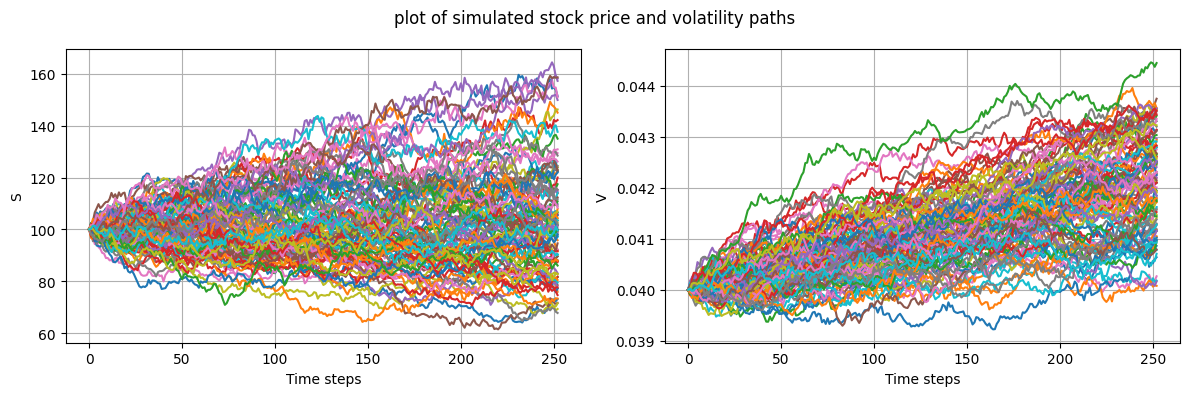

In [ ]:
#%%
"""
Plot initial 100 simulated stock price and volatility path using matplotlib
"""
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(S[:,:100])
plt.grid(True)
plt.xlabel('Time steps')
plt.ylabel('S')

plt.subplot(1, 2, 2)
plt.plot(V[:,:100])
plt.grid(True)
plt.xlabel('Time steps')
plt.ylabel('V')

plt.suptitle('plot of simulated stock price and volatility paths')
plt.tight_layout()
plt.show()

### Now fill this cell with the formula to get the value of an option

Heston Call Option price is : 8.503226301411372


In [ ]:
def BSM(S0=100, K=100, T=1, r=0.05, sigma=theta, option_type='call'):
    d1 = (math.log(S0/K) + (r+sigma**2/2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    N = norm.cdf
    V = 0
    if (option_type=='call'):
        V = S0*N(d1)-K*math.exp(-r*T)*N(d2)
    elif (option_type=='put'):
        V = K*math.exp(-r*T)*N(-d2) - S0*N(-d1)
    del N
    return V

C = BSM(sigma=0.25)
P = BSM(sigma=0.25,option_type='put')

print('ATM CALL %.2f; ATM Put %.2f' % (C,P))

ATM CALL 12.34; ATM Put 7.46
